In [9]:
import json
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.io as pio

pio.renderers.default = "notebook"
import plotly.express as px

from eda_utils import (
    read_scip_log,
    format_log_df,
    operations_plots,
    objective_function_plots,
    get_month_difference,
    get_revenue_before_eow,
    get_business_sales,
    get_comparison_stats,
)

pd.set_option("display.float_format", lambda x: "%.3f" % x)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
lp_logs_path = "lp_logs/"
# lp_logs_path = "lp_logs_backup_13_09_2023/"

In [11]:
with open(f"../{lp_logs_path}/experiments_results.json") as json_file:
    experiment_results = json.load(json_file)
with open(f"../{lp_logs_path}/params.json") as json_file:
    PARAMS = json.load(json_file)

In [12]:
successfull_exps = []
for experiment, value in experiment_results.items():
    successfull_exps.append(experiment)
    Log_df_heuristics = read_scip_log(f"../{lp_logs_path}/{experiment}_h.log")
    Log_df = read_scip_log(f"../{lp_logs_path}/{experiment}.log")

    try:
        Log_df_heuristics = format_log_df(Log_df_heuristics)
        experiment_results[experiment]["Log_df_h"] = Log_df_heuristics
        experiment_results[experiment]["obj_func_h"] = Log_df_heuristics["impact_on_obj_func"].sum()
    except KeyError:
        if experiment in successfull_exps:
            successfull_exps.remove(experiment)
    try:
        Log_df = format_log_df(Log_df)
        experiment_results[experiment]["Log_df"] = Log_df
        experiment_results[experiment]["obj_func"] = Log_df["impact_on_obj_func"].sum()
    except KeyError:
        if experiment in successfull_exps:
            successfull_exps.remove(experiment)


print(f"Number of successfull experiments: {len(successfull_exps)} out of {len(experiment_results.keys())}")

print(successfull_exps)

Number of successfull experiments: 1 out of 1
['2019_24periods']


In [13]:
# fails
[x for x in experiment_results.keys() if x not in successfull_exps]

[]

In [14]:
df_table = pd.DataFrame()
for experiment, value in experiment_results.items():
    if experiment in successfull_exps:
        series = (
            pd.Series(
                {
                    "experiment": experiment,
                    "fecha_inicio": value["fecha_inicio"],
                    "fecha_fin_ejercicio": value["fecha_fin_ejercicio"],
                    "periodos_modelo": value["periodos_modelo"],
                    "fix_prices": value["fix_prices"],
                    "lp_stock_historical_cost": value["lp_stock_history_cost"],
                    "lp_free_objective_func": value["obj_func"],
                    "lp_heur_objective_func": value["obj_func_h"],
                }
            )
            .to_frame()
            .T
        )
        df_table = pd.concat([df_table, series])

# df_table["impact"] = (
#     df_table["lp_grand_total_before_eow"] - df_table["business_grand_total"]
# ) / df_table["business_grand_total"]
# df_table["impact"] = (df_table["impact"].apply(round, args=[2]) * 100).astype(int)


# df_table.loc[df_table.experiment == "2019_24periods_real_prices"]

In [16]:
df_table

experiment fecha_inicio fecha_fin_ejercicio periodos_modelo fix_prices   
0  2019_24periods   18/01/2019          08/01/2021              24      False  \

  lp_stock_historical_cost lp_free_objective_func lp_heur_objective_func  
0               297927.539             210758.999             228140.371

In [8]:
df_table[["lp_stock_historical_cost", "lp_free_objective_func", "lp_heur_objective_func"]] = df_table[
    ["lp_stock_historical_cost", "lp_free_objective_func", "lp_heur_objective_func"]
].round(-3)

In [9]:
df_table["relative impact"] = (df_table["lp_free_objective_func"] - df_table["lp_heur_objective_func"]) / df_table[
    "lp_heur_objective_func"
]
df_table[[x for x in df_table.columns if x != "lp_stock_historical_cost"]]

df_table.columns = [
    "experiment",
    "start_date",
    "end_date",
    "periods",
    "fix_prices",
    "lp_stock_historical_cost",
    "lp_free_objective_func",
    "lp_heur_objective_func",
    "relative impact",
]

df_table[["lp_stock_historical_cost", "lp_free_objective_func", "lp_heur_objective_func"]] = df_table[
    ["lp_stock_historical_cost", "lp_free_objective_func", "lp_heur_objective_func"]
].astype(int)
df_table["relative impact"] = df_table["relative impact"].apply(lambda x: round(x, 3))
print("median impact", df_table["relative impact"].median())
df_table.columns = [x.replace("free", "baseline") for x in df_table.columns]

median impact 0.224


Text(0.05, 0.95, 'Correlation: 0.83')

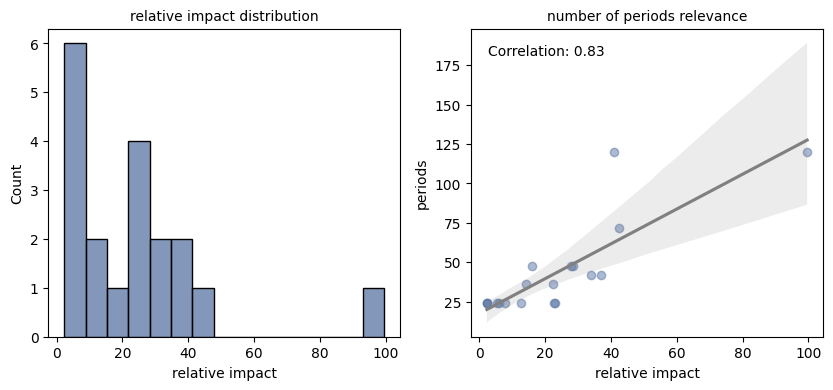

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(
    df_table["relative impact"].astype(float) * 100,
    bins=15,
    stat="count",
    ax=ax[0],
    color="#5975a4",
).set_title("relative impact distribution", size=10)

sns.regplot(
    x=df_table["relative impact"].astype(float) * 100,
    y=df_table["periods"].astype(int),
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "grey"},
    ci=95,
    color="#5975a4",
    ax=ax[1],
).set_title("number of periods relevance", size=10)
correlation = 0.83
ax[1].annotate(
    f"Correlation: {correlation}",
    xy=(0.05, 0.95),
    xycoords="axes fraction",
    fontsize=10,
    ha="left",
    va="top",
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="white", facecolor="white"),
)

In [11]:
df_table["relative impact"].astype(float).corr(df_table["periods"].astype(int))

0.8367757352329636

In [43]:
df_table["relative impact"].describe()

count   19.000
mean     0.235
std      0.227
min      0.023
25%      0.069
50%      0.224
75%      0.312
max      0.996
Name: relative impact, dtype: float64

In [44]:
experiment_results.keys()

dict_keys(['2019_24periods', 'm2019_24periods', '2020_24periods', '2019_36periods', '2019_42periods', '2019_48periods', '2019_24periods_fix_prices', 'm2019_24periods_fix_prices', '2020_24periods_fix_prices', '2019_36periods_fix_prices', '2019_42periods_fix_prices', '2019_48periods_fix_prices', '2019_120periods_fcst', '2019_120periods_fix_prices_fcst', '2023_24periods_fcst_no_trend', '2023_48periods_fcst_no_trend', '2023_72periods_fcst_no_trend', '2019_24periods_p_index_70', '2019_24periods_fix_costs_100'])

In [45]:
# experiment = "m2019_24periods"
# experiment = "2019_120periods_fcst"
# experiment = "2019_24periods"

# periods_before_eow = experiment_results[experiment]["periods_before_eow"]

Log_df = read_scip_log(f"../{lp_logs_path}/{experiment}.log")
Log_df = format_log_df(Log_df)

Log_df_h = read_scip_log(f"../{lp_logs_path}/{experiment}_h.log")
Log_df_h = format_log_df(Log_df_h)

operations_plots(
    Log_df,
    periodos_modelo=experiment_results[experiment]["periodos_modelo"],
    periods_before_eow=Log_df["t"].max(),
    EOW=False,
)

operations_plots(
    Log_df_h,
    periodos_modelo=experiment_results[experiment]["periodos_modelo"],
    periods_before_eow=Log_df_h["t"].max(),
    EOW=False,
)


# objective_function_plots(
#     Log_df,
#     periodos_modelo=experiment_results[experiment]["periodos_modelo"],
#     periods_before_eow=Log_df["t"].max(),
# )

# objective_function_plots(
#     Log_df_h,
#     periodos_modelo=experiment_results[experiment]["periodos_modelo"],
#     periods_before_eow=Log_df_h["t"].max(),
# )

In [46]:
# VENTA_DESTETE = [6, 7, 8]
# VENTA_NOVILLO_VAQUILLONA = [16, 17, 18]
# VENTA_PESADOS = [30, 31, 32, 33, 34, 35, 36]

# #Log_df_h['class'] = Log_df_h['class'].astype(int)


# conditions = [
#     Log_df_h["t"].isin(VENTA_DESTETE) & (Log_df_h["class"].isin(['1', '2'])) & (Log_df_h["var"] == 'y'),
#     Log_df_h["t"].isin(VENTA_NOVILLO_VAQUILLONA) & (Log_df_h["class"].isin(['1', '2'])) & (Log_df_h["var"] == 'y'),
#     Log_df_h["t"].isin(VENTA_PESADOS) & (Log_df_h["class"].isin(['1', '2'])) & (Log_df_h["var"] == 'y'),
#     (Log_df_h["class"] == '3') & (Log_df_h["var"] == 'y'),
# ]

# choice_list = ["S1", "S2", "S3", "S4"]
# Log_df_h["selling_stage"] = np.select(conditions,choicelist=choice_list)


# Log_df_h.loc[Log_df_h.selling_stage != '0'].groupby('selling_stage').sum()

In [47]:
# VENTA_DESTETE = [6, 7, 8]
# VENTA_NOVILLO_VAQUILLONA = [16, 17, 18]
# VENTA_PESADOS = [30, 31, 32, 33, 34, 35, 36]

# #Log_df['class'] = Log_df['class'].astype(int)


# conditions = [
#     Log_df["t"].isin(VENTA_DESTETE) & (Log_df["class"].isin(['1', '2'])) & (Log_df["var"] == 'y'),
#     Log_df["t"].isin(VENTA_NOVILLO_VAQUILLONA) & (Log_df["class"].isin(['1', '2'])) & (Log_df["var"] == 'y'),
#     Log_df["t"].isin(VENTA_PESADOS) & (Log_df["class"].isin(['1', '2'])) & (Log_df["var"] == 'y'),
#     (Log_df["class"] == '3') & (Log_df["var"] == 'y'),
# ]

# choice_list = ["S1", "S2", "S3", "S4"]
# Log_df["selling_stage"] = np.select(conditions,choicelist=choice_list)


# Log_df.loc[Log_df.selling_stage != '0'].groupby('selling_stage').sum()

In [48]:
## ! Calculation of m2019_24periods decision to sell c3 stock at period 2 vs mainatining and giving more newborns on period 14

# maintenance costs masks
mask_mant12 = (
    (Log_df_h["var"] == "x")
    & (Log_df_h["t"].between(14, Log_df_h["t"].max()))
    & (Log_df_h["class"].isin(["2", "1"]))
    & (Log_df_h["age"].between(0, 6))
)

mask_mant2added = (
    (Log_df_h["var"] == "x")
    & (Log_df_h["t"].between(20, Log_df_h["t"].max()))
    & (Log_df_h["class"].isin(["2", "1"]))
    & (Log_df_h["age"].between(0, 10))
)

mask_mant3 = (
    (Log_df_h["var"] == "x")
    & (Log_df_h["t"].between(3, 14))
    & (Log_df_h["class"].isin(["3"]))
    & (Log_df_h["age"].between(63, 74))
)

# selling masks
mask_sell1 = (
    (Log_df_h["var"] == "y") & (Log_df_h["t"] == 20) & (Log_df_h["class"].isin(["1"])) & (Log_df_h["age"] == 6)
)
mask_sell2 = (
    (Log_df_h["var"] == "y") & (Log_df_h["t"] == 20) & (Log_df_h["class"].isin(["2"])) & (Log_df_h["age"] == 6)
)

# selling unitary value
manthalf12 = (Log_df_h[mask_mant12].unit_impact_on_obj_func.sum() / 2) * 0.86
manthalf2added = (Log_df_h[mask_mant2added].unit_impact_on_obj_func.sum() / 2) * 0.86 * 0.7
mant3 = Log_df_h[mask_mant3].unit_impact_on_obj_func.sum()

# maintenance unitary values
sellhalf1 = (Log_df_h[mask_sell1].unit_impact_on_obj_func.sum() / 2) * 0.86
sellhalf230percent = ((Log_df_h[mask_sell2].unit_impact_on_obj_func.sum() / 2) * 0.86) * 0.3

# result
(sellhalf1 + sellhalf230percent) + (manthalf12 + mant3 + manthalf2added)

# c3 price is the same in all periods

-145.34919683497372

In [49]:
print(
    (Log_df.loc[Log_df["var"] == "n"].sum()["value"] - Log_df_h.loc[Log_df_h["var"] == "n"].sum()["value"])
    / Log_df_h.loc[Log_df_h["var"] == "n"].sum()["value"],
    (Log_df.loc[Log_df["var"] == "w"].sum()["value"] - Log_df_h.loc[Log_df_h["var"] == "w"].sum()["value"])
    / Log_df_h.loc[Log_df_h["var"] == "w"].sum()["value"],
)

0.07526881720430101 -1.0


In [50]:
# experiment = "m2019_24periods"

experiment = "2019_120periods_fcst"
# periods_before_eow = experiment_results[experiment]["periods_before_eow"]

Log_df = read_scip_log(f"../{lp_logs_path}/{experiment}.log")
Log_df = format_log_df(Log_df)

Log_df_h = read_scip_log(f"../{lp_logs_path}/{experiment}_h.log")
Log_df_h = format_log_df(Log_df_h)

max_periodos = Log_df["t"].max()
x_max = Log_df.loc[Log_df["var"] == "x"].value.max()
x_min = Log_df.loc[Log_df["var"] == "x"].value.min()
y_max = Log_df.loc[Log_df["var"] == "y"].value.max()
y_min = Log_df.loc[Log_df["var"] == "y"].value.min()

stock = Log_df.loc[(Log_df["var"] == "x")].sort_values(by=["class", "age"], ascending=[True, False])
stock["variant"] = "free"

stock_2 = Log_df_h.loc[(Log_df_h["var"] == "x")].sort_values(by=["class", "age"], ascending=[True, False])

stock_2["variant"] = "baseline"

stock_all = pd.concat([stock, stock_2])
stock_all.rename(columns={"value": "quantity"}, inplace=True)

fig = px.bar(
    stock_all,
    x="t",
    y="quantity",
    color="age",
    color_continuous_scale="Blugrn",  # color_continuous_scale="Blugrn",
    facet_col="class",
    title=f"stock per period by age and class - experiment: {experiment}",
    range_x=[0, max_periodos],
    range_y=[0, x_max],
    facet_row="variant",
)


fig.update_traces(width=1)
fig.update_layout(
    xaxis_title="periods",
    xaxis2_title="periods",
    xaxis3_title="periods",
    title=dict(font=dict(size=14)),
)
fig.show()

In [51]:
# experiment = "m2019_24periods"

experiment = "2019_120periods_fcst"
# periods_before_eow = experiment_results[experiment]["periods_before_eow"]

Log_df = read_scip_log(f"../{lp_logs_path}/{experiment}.log")
Log_df = format_log_df(Log_df)

Log_df_h = read_scip_log(f"../{lp_logs_path}/{experiment}_h.log")
Log_df_h = format_log_df(Log_df_h)

max_periodos = Log_df["t"].max()
x_max = Log_df.loc[Log_df["var"] == "x"].value.max()
x_min = Log_df.loc[Log_df["var"] == "x"].value.min()
y_max = Log_df.loc[Log_df["var"] == "y"].value.max()
y_min = Log_df.loc[Log_df["var"] == "y"].value.min()

stock = Log_df.loc[(Log_df["var"] == "y")].sort_values(by=["class", "age"], ascending=[True, False])
stock["variant"] = "free"

stock_2 = Log_df_h.loc[(Log_df_h["var"] == "y")].sort_values(by=["class", "age"], ascending=[True, False])

stock_2["variant"] = "baseline"

stock_all = pd.concat([stock, stock_2])
stock_all.rename(columns={"value": "quantity"}, inplace=True)

fig = px.bar(
    stock_all,
    x="t",
    y="quantity",
    color="age",
    color_continuous_scale="Sunset",  # color_continuous_scale="Blugrn",
    facet_col="class",
    title=f"sales per period by age and class - experiment: {experiment}",
    range_x=[0, max_periodos],
    range_y=[0, x_max],
    facet_row="variant",
)


fig.update_traces(width=1)
fig.update_layout(
    xaxis_title="periods",
    xaxis2_title="periods",
    xaxis3_title="periods",
    title=dict(font=dict(size=14)),
)

fig.update_traces(width=3)  # You can adjust the width (0.5 in this case) to your preference

fig.show()

In [52]:
def label_sales(df):
    _df = df.copy(deep=True)
    _df["class"] = _df["class"].astype(str)

    # Create conditions for each case
    condition_s1 = (
        (_df["var"] == "y") & (_df["class"].isin(["1", "2"])) & (_df["age"].between(6, 8)) & (_df["value"] > 0)
    )
    condition_s2 = (
        (_df["var"] == "y") & (_df["class"].isin(["1", "2"])) & (_df["age"].between(16, 18)) & (_df["value"] > 0)
    )
    condition_s3 = (
        (_df["var"] == "y") & (_df["class"].isin(["1", "2"])) & (_df["age"].between(30, 36)) & (_df["value"] > 0)
    )
    condition_s4 = (_df["var"] == "y") & (_df["class"] == "3")

    # Define choices and labels
    choices = [condition_s1, condition_s2, condition_s3, condition_s4]
    labels = ["S1", "S2", "S3", "S4"]

    # Default label for cases not matching any conditions
    default_label = "no_sell"

    # Apply np.select to create a new column 'sell_label'
    _df["sell_label"] = np.select(choices, labels, default=default_label)

    _df_sales = _df.loc[(_df["var"] == "y")]
    _df_sales = _df_sales.loc[_df_sales["sell_label"] != "no_sell"]

    return _df_sales


Log_df_h_sales = label_sales(Log_df_h)
Log_df_sales = label_sales(Log_df)

Log_df_sales_g = Log_df_sales.groupby("sell_label").sum()["value"]
Log_df_h_sales_g = Log_df_h_sales.groupby("sell_label").sum()["value"]
Log_df_sales_g.name = "free"
Log_df_h_sales_g.name = "heur"
comp_sales = pd.DataFrame(Log_df_h_sales_g).join(pd.DataFrame(Log_df_sales_g))
comp_sales["var"] = (comp_sales["free"] - comp_sales["heur"]) / comp_sales["heur"]
comp_sales

heur     free   var
sell_label                        
S1         4972.119 7834.225 0.576
S2         1133.027 3100.668 1.737
S3           52.000   52.000 0.000
S4         1699.037 2555.676 0.504

In [53]:
comparison_df = pd.DataFrame()
for experiment, value in experiment_results.items():
    if experiment in successfull_exps:
        Log_df = read_scip_log(f"../{lp_logs_path}/{experiment}.log")
        Log_df = format_log_df(Log_df)
        Log_df_h = read_scip_log(f"../{lp_logs_path}/{experiment}_h.log")
        Log_df_h = format_log_df(Log_df_h)
        stats = get_comparison_stats(Log_df, Log_df_h)
        stats_df = pd.DataFrame.from_dict(stats, orient="index").T
        stats_df.rename(index={0: experiment}, inplace=True)
        comparison_df = pd.concat([comparison_df, stats_df])

comparison_df["stock_history_cost"] = [
    experiment_results[x]["lp_stock_history_cost"] for x in experiment_results.keys() if x in successfull_exps
]

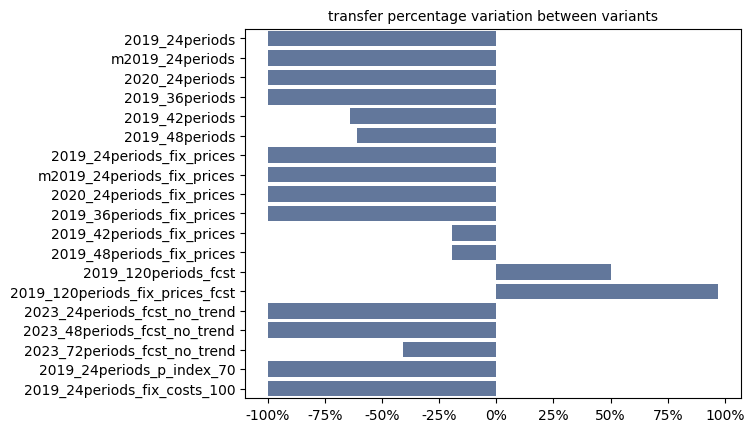

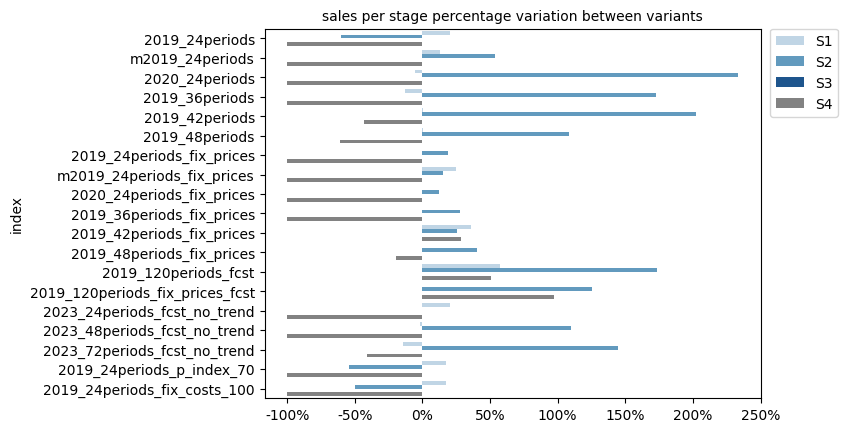

pearson correlation 0.9263767040136639


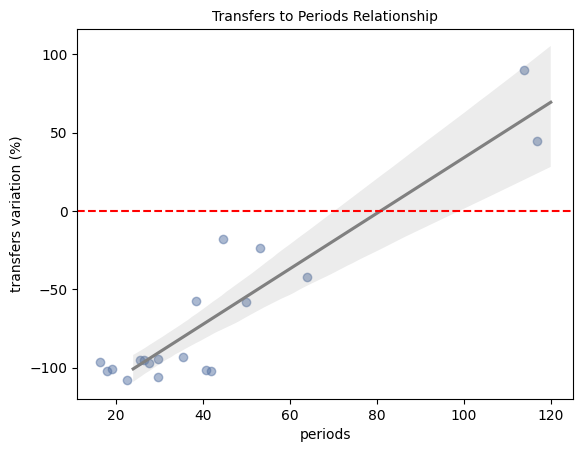

In [54]:
ax = sns.barplot(data=comparison_df, y=comparison_df.index, x="var_traspasos", color="#5975a4")
vals = ax.get_xticks()
ax.set_xticklabels([str(int(x)) + "%" for x in vals])
ax.set_xlabel("")
ax.set_title("transfer percentage variation between variants", size=10)

plt.show()

melt_ventas = comparison_df.reset_index().melt(
    id_vars=["index"],
    value_vars=["destete", "venta livianos", "venta pesados", "venta c3"],
    var_name="category",
)

mapping = {
    "destete": "S1",
    "venta livianos": "S2",
    "venta pesados": "S3",
    "venta c3": "S4",
}
melt_ventas["category"] = melt_ventas["category"].replace(mapping)


palette = {
    "S1": sns.color_palette("Blues")[1],
    "S2": sns.color_palette("Blues")[3],
    "S3": sns.color_palette("Blues")[5],
    "S4": sns.color_palette("Greys")[3],
}

ax = sns.barplot(data=melt_ventas, y="index", x="value", hue="category", palette=palette)
vals = ax.get_xticks()
ax.set_xticklabels([str(int(x)) + "%" for x in vals])
ax.set_xlabel("")
ax.set_title("sales per stage percentage variation between variants", size=10)
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.show()

comparison_df["var_traspasos"] = comparison_df["var_traspasos"].astype(int)
comparison_df["periods"] = comparison_df["periods"].astype(int)

fig = sns.regplot(
    data=comparison_df,
    y="var_traspasos",
    x="periods",
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "grey"},
    y_jitter=8,
    x_jitter=8,
    ci=95,
    color="#5975a4",
    # ax=ax[1],
)
fig.axhline(y=0, color="r", linestyle="--")
fig.set_ylabel("transfers variation (%)")
fig.set_title("Transfers to Periods Relationship", size=10)
print("pearson correlation", comparison_df["periods"].corr(comparison_df["var_traspasos"]))

In [55]:
comparison_df.loc[comparison_df.index == "m2019_24periods"]

var_obj_func  var_traspasos trasp_h trasp  periods   
m2019_24periods       22.874           -100  88.580 0.000       24  \

                                                          stock_t0 destete   
m2019_24periods  class
1   357.000
2   435.000
3   515.000
Name...  13.174  \

                venta c3 venta livianos venta pesados  stock_history_cost  
m2019_24periods -100.000         53.373         0.000          287327.388

In [56]:
# melt_ventas = comparison_df.reset_index().melt(
#     id_vars=["index"],
#     value_vars=["class1", "class2", "class3"],
#     var_name="category",
# )

# melt_ventas

# melt_ventas["category"] = melt_ventas["category"].replace(mapping)


# palette = {
#     "class1": sns.color_palette("Blues")[1],
#     "class2": sns.color_palette("Blues")[3],
#     "class3": sns.color_palette("Blues")[5],
# }

# ax = sns.barplot(
#     data=melt_ventas, y="index", x="value", hue="category", palette=palette
# )
# vals = ax.get_xticks()
# ax.set_xticklabels([str(int(x)) + "%" for x in vals])
# ax.set_xlabel("")
# ax.set_title("sales percentage variation between variants", size=10)
# ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
# plt.show()

In [57]:
# sns.palplot(sns.color_palette("Blues"))

# sns.palplot()

2019_24periods
m2019_24periods
2020_24periods
2019_36periods
2019_42periods
2019_48periods
2019_24periods_fix_prices
m2019_24periods_fix_prices
2020_24periods_fix_prices
2019_36periods_fix_prices
2019_42periods_fix_prices
2019_48periods_fix_prices
2019_120periods_fcst
2019_120periods_fix_prices_fcst
2023_24periods_fcst_no_trend
2023_48periods_fcst_no_trend
2023_72periods_fcst_no_trend
2019_24periods_p_index_70
2019_24periods_fix_costs_100


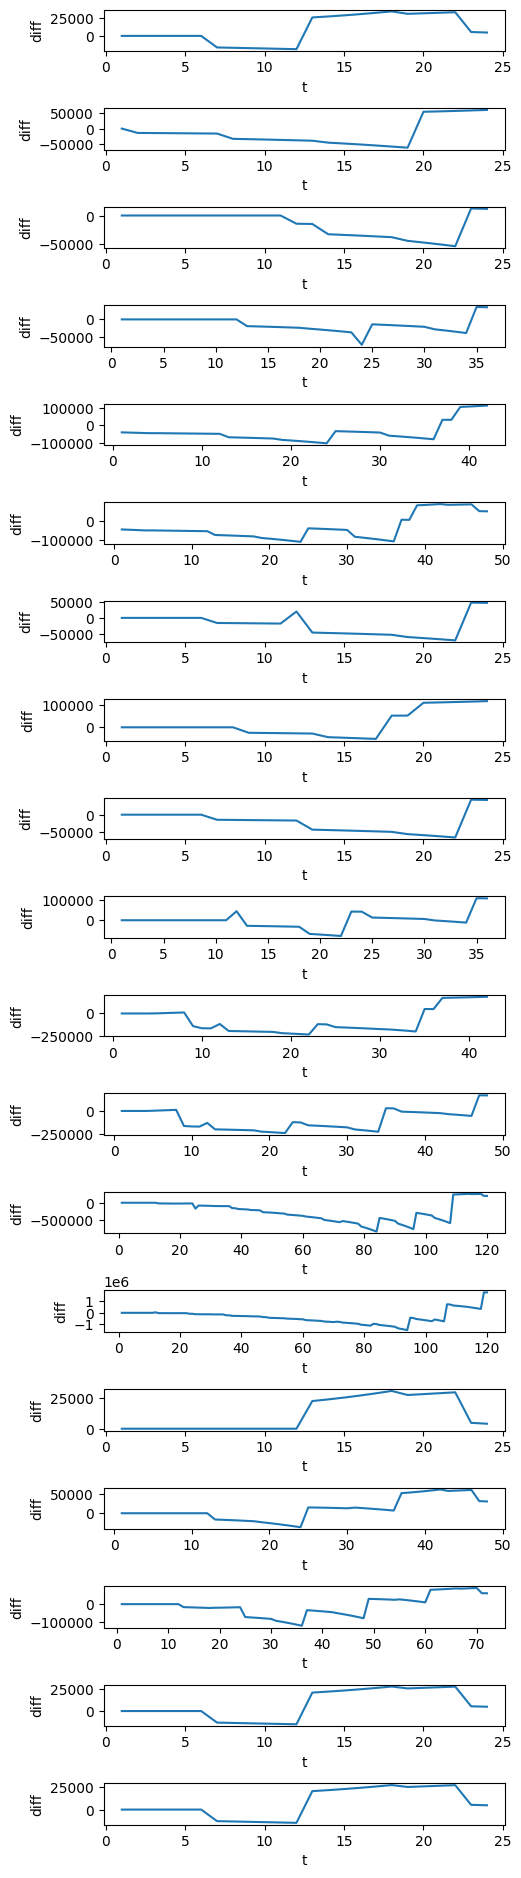

In [58]:
# lineplot objective func

concat_df = pd.DataFrame()
for experiment, value in experiment_results.items():
    if experiment in successfull_exps:
        Log_df = read_scip_log(f"../{lp_logs_path}/{experiment}.log")
        Log_df = format_log_df(Log_df)
        Log_df_h = read_scip_log(f"../{lp_logs_path}/{experiment}_h.log")
        Log_df_h = format_log_df(Log_df_h)

        assert (
            Log_df.loc[(Log_df["var"] == "y") & (Log_df["value"].astype(int) > 0) & (Log_df["class"] != 3)][
                "value"
            ].min()
            >= 10
        ), f"experiment {experiment}"
        assert (
            Log_df_h.loc[(Log_df_h["var"] == "y") & (Log_df_h["value"].astype(int) > 0) & (Log_df_h["class"] != 3)][
                "value"
            ].min()
            >= 10
        ), f"experiment h {experiment}"

        group_obj_func = Log_df.groupby(["var", "t"])["impact_on_obj_func"].sum().reset_index()
        cumsum_df = Log_df.groupby("t").sum()["impact_on_obj_func"].reset_index()
        cumsum_df["cumsum_obj_func"] = cumsum_df["impact_on_obj_func"].cumsum()

        group_obj_func = Log_df_h.groupby(["var", "t"])["impact_on_obj_func"].sum().reset_index()
        cumsum_df_h = Log_df_h.groupby("t").sum()["impact_on_obj_func"].reset_index()
        cumsum_df_h["cumsum_obj_func"] = cumsum_df_h["impact_on_obj_func"].cumsum()

        relative_diff = (cumsum_df["cumsum_obj_func"] - cumsum_df_h["cumsum_obj_func"]) / cumsum_df_h[
            "cumsum_obj_func"
        ]
        diff = cumsum_df["cumsum_obj_func"] - cumsum_df_h["cumsum_obj_func"]

        exp_df = pd.DataFrame(
            {
                "t": cumsum_df["t"],
                "relative_diff": relative_diff,
                "diff": diff,
                "experiment": experiment,
            }
        )
        concat_df = pd.concat([concat_df, exp_df])
        concat_df = concat_df.loc[concat_df.t != 0]

fig, axs = plt.subplots(len(concat_df.experiment.unique()), 1, figsize=(5, concat_df.experiment.nunique()))
fig.tight_layout(pad=2.0)
for exp, exp_nr in zip(concat_df.experiment.unique(), range(0, len(concat_df.experiment.unique()))):
    print(exp)
    sns.lineplot(
        data=concat_df.loc[concat_df["experiment"] == exp],
        x="t",
        y="diff",
        ax=axs[exp_nr],
    )

In [59]:
last_sign_change = concat_df.loc[concat_df["diff"] < 0].groupby("experiment").max()["t"] + 1
last_sign_change.name = "positive cum diff period"
comparison_df = comparison_df.join(last_sign_change)

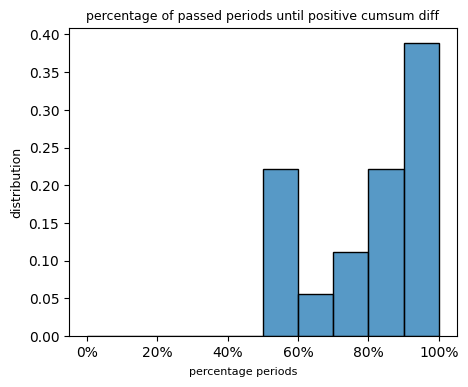

In [60]:
comparison_df["positive objectivecum diff relative"] = (
    comparison_df["positive cum diff period"] / comparison_df["periods"]
) * 100

fig = plt.figure(figsize=(5, 4))
ax = sns.histplot(
    comparison_df["positive objectivecum diff relative"],
    bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    stat="probability",
)
vals = ax.get_xticks()
ax.set_xticklabels([str(int(x)) + "%" for x in vals])
ax.set_title("percentage of passed periods until positive cumsum diff", size=9)
ax.set_xlabel(
    "percentage periods",
    size=8,
    labelpad=4,
)
ax.set_ylabel("distribution", size=9)
ax.xaxis.set_label_coords(0.45, -0.1)
# ax.set_xlabel("")
# ax.set_xticks([0,10,20,30,40,50, 60, 70, 80, 90, 100])
# ax.set_xticklabels([10,20,30,40,50, 60, 70, 80, 90, 100])

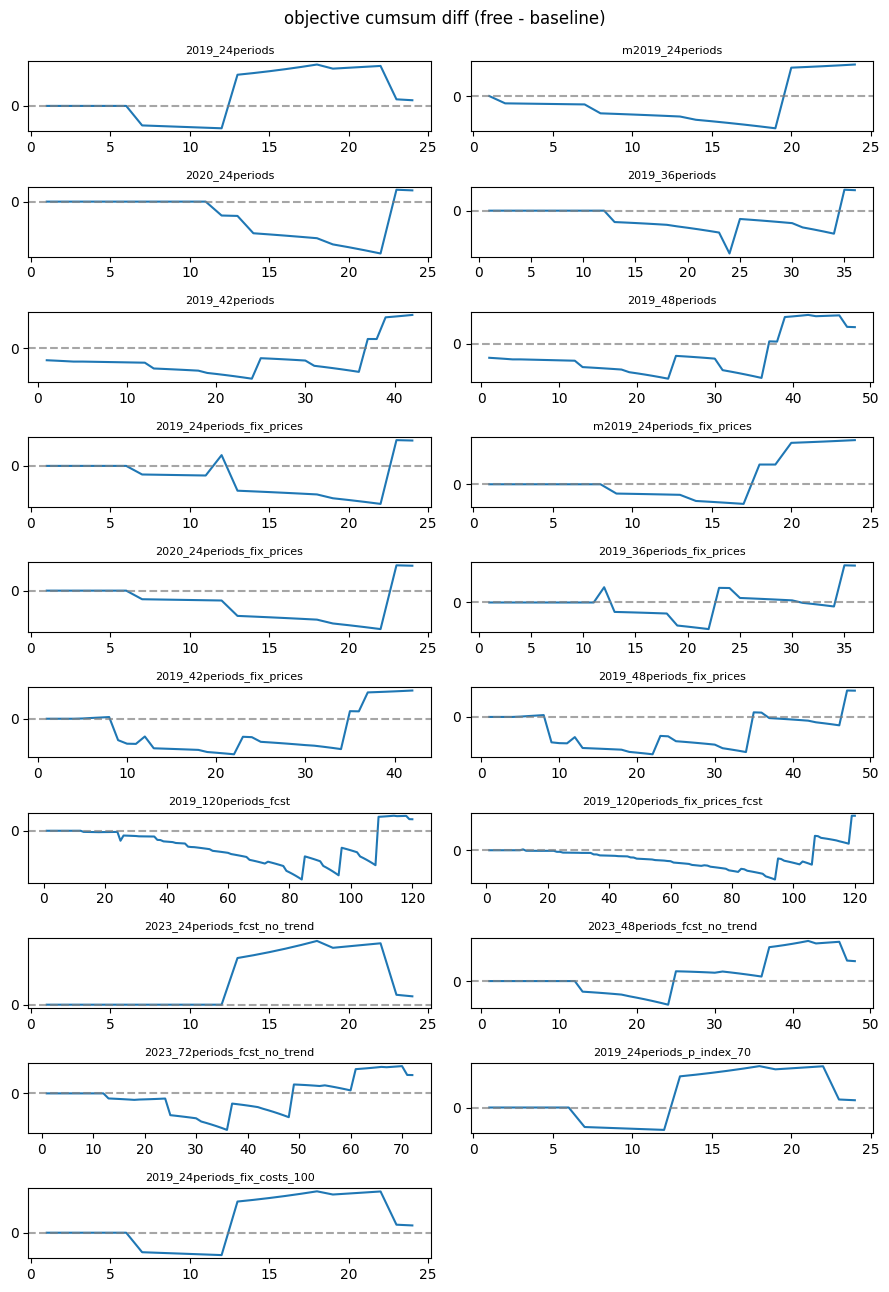

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Your existing code for concatenating data goes here...

# Create a list of unique experiments
unique_experiments = concat_df["experiment"].unique()
num_experiments = len(unique_experiments)

# Calculate the number of rows and columns for subplots
num_cols = 2
num_rows = (num_experiments + 1) // num_cols

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(9, 1.3 * num_rows))
axs = axs.flatten()
fig.suptitle("objective cumsum diff (free - baseline)", size=12, y=0.99)  # or plt.suptitle('Main title')

# Loop through experiments and plot data
for exp_nr, exp in enumerate(unique_experiments):
    fig = sns.lineplot(
        data=concat_df.loc[concat_df["experiment"] == exp],
        x="t",
        y="diff",
        ax=axs[exp_nr],
    )
    fig.axhline(y=0, color="grey", linestyle="--", alpha=0.7)
    axs[exp_nr].set_title(exp, size=8)
    axs[exp_nr].set_yticks([0])

    fig.set(ylabel=None)
    fig.set(xlabel=None)
    fig.set(yticklabels=[0])  # remove the tick labels
    # fig.tick_params(left=False)  # remove the ticks

# Remove any empty subplots
# for exp_nr in range(num_experiments, num_rows * num_cols):
#    fig.delaxes(axs[exp_nr])
# axs.delaxes(axs[num_rows,num_cols])

# figaxs[19].set_axis_off()

axs[19].set_axis_off()

# for ax in axs:
#    #ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
#    ax.set_yticks(0)


plt.tight_layout()
plt.show()

plot precios


In [62]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

costs = pd.read_csv("../model_inputs/costs.dat", sep="\t", index_col=False)
costs.columns = ["period", "month_age", "class", "cost", "remove"]
costs["class"] = costs["class"].astype(str)
costs["period"] = costs["period"].astype(int)
cost_filter = costs.loc[costs.period == 2]
cost_filter = cost_filter.loc[cost_filter.cost != 0]

# fig, ax = plt.subplots(3, 1)
# fig.set_size_inches(8, 7)
# sns.lineplot(
#     data=cost_filter.loc[cost_filter["class"] == "1"],
#     x="month_age",
#     y="cost",
#     hue="class",
#     ax=ax[0],
# )
# sns.lineplot(
#     data=cost_filter.loc[cost_filter["class"] == "2"],
#     x="month_age",
#     y="cost",
#     hue="class",
#     ax=ax[1],
# )
# sns.lineplot(
#     data=cost_filter.loc[cost_filter["class"] == "3"],
#     x="month_age",
#     y="cost",
#     hue="class",
#     ax=ax[2],
# )
# ax[0].set_ylim(-3, cost_filter["cost"].max() + 1)
# ax[1].set_ylim(-3, cost_filter["cost"].max() + 1)
# ax[2].set_ylim(-3, cost_filter["cost"].max() + 1)

In [63]:
VENTA_DESTETE = [6, 7, 8]
VENTA_NOVILLO_VAQUILLONA = [16, 17, 18]
VENTA_PESADOS = [30, 31, 32, 33, 34, 35, 36]

In [64]:
cost_filter["class"] = np.where(cost_filter["class"] == "1", "Class 1", cost_filter["class"])
cost_filter["class"] = np.where(cost_filter["class"] == "2", "Class 2", cost_filter["class"])
cost_filter["class"] = np.where(cost_filter["class"] == "3", "Class 3", cost_filter["class"])

Text(0.5, 1.0, 'cost per period per class')

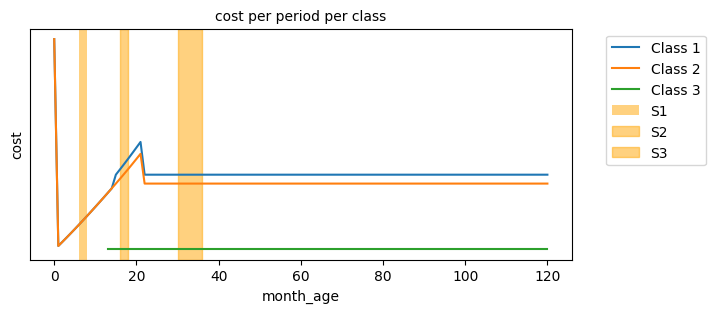

In [67]:
fig, ax = plt.subplots(figsize=(7, 3))

sns.lineplot(data=cost_filter, x="month_age", y="cost", hue="class", ax=ax)
ax.axvspan(6, 8, alpha=0.5, facecolor="orange", label="S1")
ax.axvspan(16, 18, alpha=0.5, color="orange", label="S2")
ax.axvspan(30, 36, alpha=0.5, color="orange", label="S3")
plt.yticks([])  # This line removes the ticks on the y-axis


ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
ax.set_title("cost per period per class", size=10)

In [66]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# Original dictionary
exp_grid_base = {
    "2019_periods": {
        "fecha_inicio": "18/01/2019",
        "periodos_modelo": 24,
        "fecha_fin_ejercicio": "08/01/2021",
        "fix_prices": False,
        "mantain_c3_stock": 1,
    },
    "2019_periods_fix_prices": {
        "fecha_inicio": "18/01/2019",
        "periodos_modelo": 24,
        "fecha_fin_ejercicio": "08/01/2021",
        "fix_prices": True,
        "mantain_c3_stock": 1,
    },
}

# Expansion parameters
start_periods = 24
end_periods = 120
step = 8


# Generate extra keys
exp_grid = {}
for key, value in exp_grid_base.items():
    for i in range(start_periods, end_periods + step, step):
        new_key = f"{key}{i}_periods"
        new_value = value.copy()
        new_value["periodos_modelo"] = i
        new_value["fecha_fin_ejercicio"] = (
            datetime.strptime("18/01/2019", "%d/%m/%Y") + relativedelta(months=i)
        ).strftime("%d/%m/%Y")
        exp_grid[new_key] = new_value

exp_grid

{'2019_periods24_periods': {'fecha_inicio': '18/01/2019',
  'periodos_modelo': 24,
  'fecha_fin_ejercicio': '18/01/2021',
  'fix_prices': False,
  'mantain_c3_stock': 1},
 '2019_periods32_periods': {'fecha_inicio': '18/01/2019',
  'periodos_modelo': 32,
  'fecha_fin_ejercicio': '18/09/2021',
  'fix_prices': False,
  'mantain_c3_stock': 1},
 '2019_periods40_periods': {'fecha_inicio': '18/01/2019',
  'periodos_modelo': 40,
  'fecha_fin_ejercicio': '18/05/2022',
  'fix_prices': False,
  'mantain_c3_stock': 1},
 '2019_periods48_periods': {'fecha_inicio': '18/01/2019',
  'periodos_modelo': 48,
  'fecha_fin_ejercicio': '18/01/2023',
  'fix_prices': False,
  'mantain_c3_stock': 1},
 '2019_periods56_periods': {'fecha_inicio': '18/01/2019',
  'periodos_modelo': 56,
  'fecha_fin_ejercicio': '18/09/2023',
  'fix_prices': False,
  'mantain_c3_stock': 1},
 '2019_periods64_periods': {'fecha_inicio': '18/01/2019',
  'periodos_modelo': 64,
  'fecha_fin_ejercicio': '18/05/2024',
  'fix_prices': False,
